# Importing the packages

In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import os
import warnings
warnings.filterwarnings("ignore")

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/mall-customers/Mall_Customers.csv


# Loading Data 

In [3]:
df = pd.read_csv('/kaggle/input/mall-customers/Mall_Customers.csv')
df = df.rename({"Annual Income (k$)":"salary_pa","Spending Score (1-100)":"spending_score"},axis=1)

In [4]:
df.head()

,CustomerID,Genre,Age,salary_pa,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Genre           200 non-null    object
 2   Age             200 non-null    int64 
 3   salary_pa       200 non-null    int64 
 4   spending_score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


- From the data info we see that our data has zero null values
- The data types are int or object

# Exploratory Data Analysis

In [6]:
df.describe()

,CustomerID,Age,salary_pa,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


From the data summary statistics we see that:

- Our customers have an average age of **39** years.
- The olderest customer is **70** years while the youngest is **18** years old.
- The average annual salary of our customes is 61K.
- The customer annual salary ranges from 15K to 137K.

<function matplotlib.pyplot.show(close=None, block=None)>

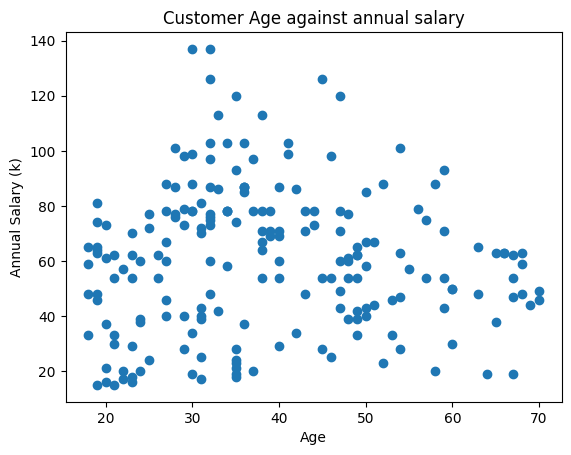

In [7]:
x=df["Age"]
y=df["salary_pa"]
plt.title("Customer Age against annual salary")
plt.xlabel("Age")
plt.ylabel("Annual Salary (k)")
plt.scatter(x,y)
plt.show

In [8]:
cust_above_100 =df[df["salary_pa"] > 120]
print(f"The are {len(cust_above_100)} customers earning above 120K")
print(f"The age range for this earning is {cust_above_100['Age'].min()}-{cust_above_100['Age'].max()}")

The are 4 customers earning above 120K
The age range for this earning is 30-45


- The annual salary across the customer ages is very sparce with no clear evident trend but the highest earning customer lay in the age range of 30 to 45.
- This makes sens as that is the prime age of the typical working class of people.

<function matplotlib.pyplot.show(close=None, block=None)>

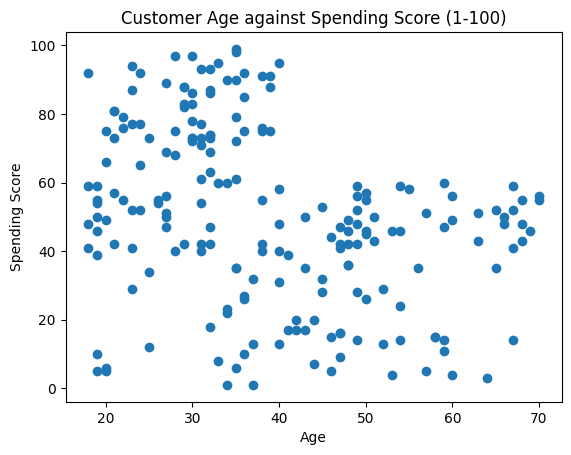

In [9]:
x=df["Age"]
y=df["spending_score"]
plt.title("Customer Age against Spending Score (1-100)")
plt.xlabel("Age")
plt.ylabel("Spending Score")
plt.scatter(x,y)
plt.show

In [10]:
cust_above_100 =df[df["spending_score"] > 80]
print(f"The are {len(cust_above_100)} customers spending over 80")
print(f"The age range for this spending score is {cust_above_100['Age'].min()}-{cust_above_100['Age'].max()}")

The are 30 customers spending over 80
The age range for this spending score is 18-40


- The customers with a 80% and above spending score are in the age range of 18 to 40
- This support a theory that young and working class people tend to spend more than older people.

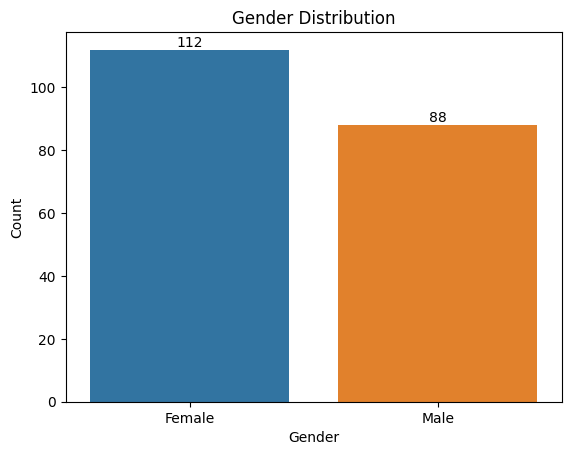

In [11]:
gender_counts = df['Genre'].value_counts()

sns.barplot(x=gender_counts.index, y=gender_counts.values)

for i, value in enumerate(gender_counts.values):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')
    
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()

# Feature Engineering

In [12]:
df['gender_binary'] = df['Genre'].map({'Male': 0, 'Female': 1})

In [13]:
df.head()

,CustomerID,Genre,Age,salary_pa,spending_score,gender_binary
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,1
3,4,Female,23,16,77,1
4,5,Female,31,17,40,1


In [14]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'salary_pa', 'spending_score',
       'gender_binary'],
      dtype='object')

# Building a Model

In [15]:
X = df[["Age","salary_pa", "gender_binary"]]
y = df["spending_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [17]:
model = LinearRegression()

model.fit(X_train_scaled, y_train)

LinearRegression()

In [18]:
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 480.673141707248


## KMeans Clustering Model

**Definition**: K-Means is an unsupervised learning algorithm that partitions customers into K clusters based on similarities in their features.

**Key advantage**: Simple and scalable for large datasets.

In [19]:
features = ['Age', 'salary_pa', 'spending_score', 'gender_binary']

In [20]:
# standardize numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'salary_pa', 'spending_score'])])

## Finding the optimal k-value using the Elbow method

The **Elbow Method** is a technique used to determine the optimal number of clusters (K) in K-Means clustering. It works by plotting the **Within-Cluster Sum of Squares (WCSS)** or **Inertia** against different values of K and identifying the point where the decrease in WCSS becomes less significant (forming an "elbow" in the plot). This point is considered the optimal number of clusters.

**Within-Cluster Sum of Squares (WCSS) or Inertia** - is the sum of the squared distances between each data point and the centroid of its assigned cluster, measuring how tightly the data points are grouped in each cluster.

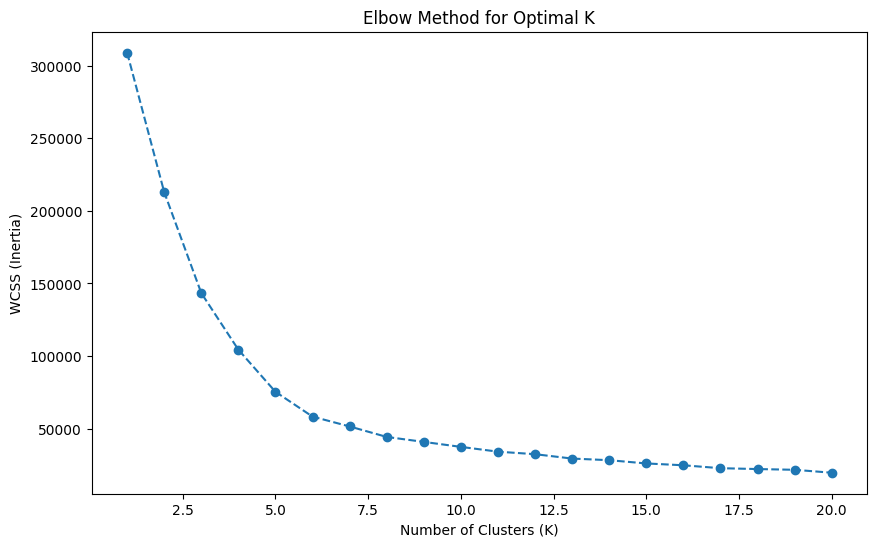

In [33]:
# Features to cluster
X = df[['Age', 'salary_pa', 'gender_binary','spending_score']] 

# List to store WCSS for each K value
wcss = []

# Loop over a range of K values (1 to 20)
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # inertia_ gives the WCSS

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.show()

From the elbow method it looks like the elbow is at **k=6** or **k=7**

In [43]:
# Build the KMeans pipeline
kmeans_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=6, random_state=42))
])

In [44]:
# Fit the pipeline to the data
kmeans_pipeline.fit(df[features])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'salary_pa',
                                                   'spending_score'])])),
                ('kmeans', KMeans(n_clusters=6, random_state=42))])

In [45]:
# Get the cluster labels
df['Cluster'] = kmeans_pipeline.predict(df[features])

In [46]:
# View the resulting clusters
print(df[['CustomerID', 'Genre', 'Age', 'salary_pa', 'spending_score', 'Cluster']])

     CustomerID   Genre  Age  salary_pa  spending_score  Cluster
0             1    Male   19         15              39        0
1             2    Male   21         15              81        0
2             3  Female   20         16               6        5
3             4  Female   23         16              77        0
4             5  Female   31         17              40        5
..          ...     ...  ...        ...             ...      ...
195         196  Female   35        120              79        4
196         197  Female   45        126              28        2
197         198    Male   32        126              74        4
198         199    Male   32        137              18        2
199         200    Male   30        137              83        4

[200 rows x 6 columns]


In [47]:
df.Cluster.unique()

array([0, 5, 1, 3, 4, 2], dtype=int32)

## When k=6 the clustering is as follows

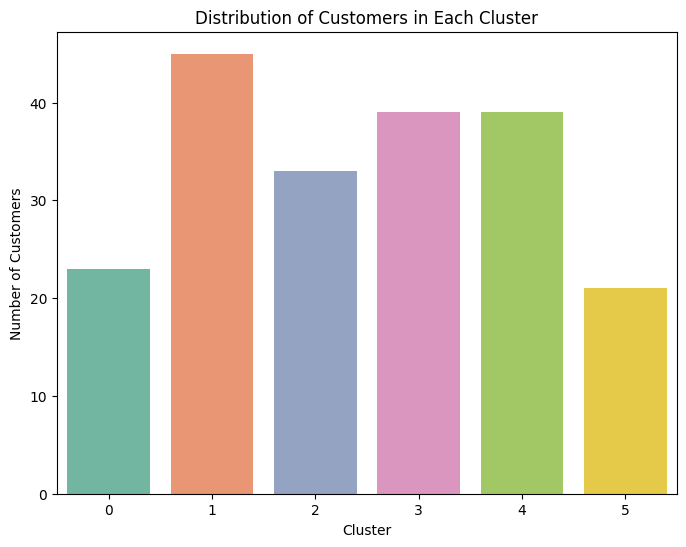

In [48]:
# Plot the distribution of the clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=df, palette='Set2')
plt.title('Distribution of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

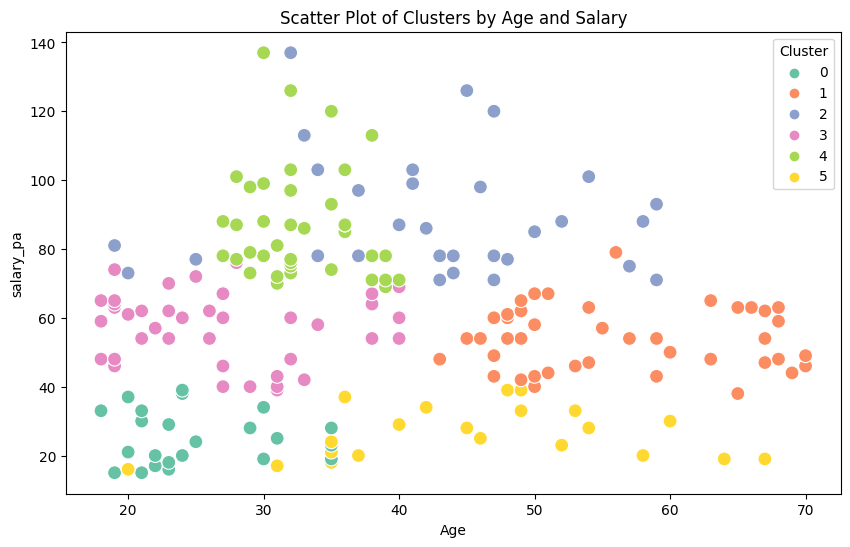

In [31]:
# Scatter plot of Age vs Salary with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='salary_pa', hue='Cluster', palette='Set2', s=100)
plt.title('Scatter Plot of Clusters by Age and Salary')
plt.show()

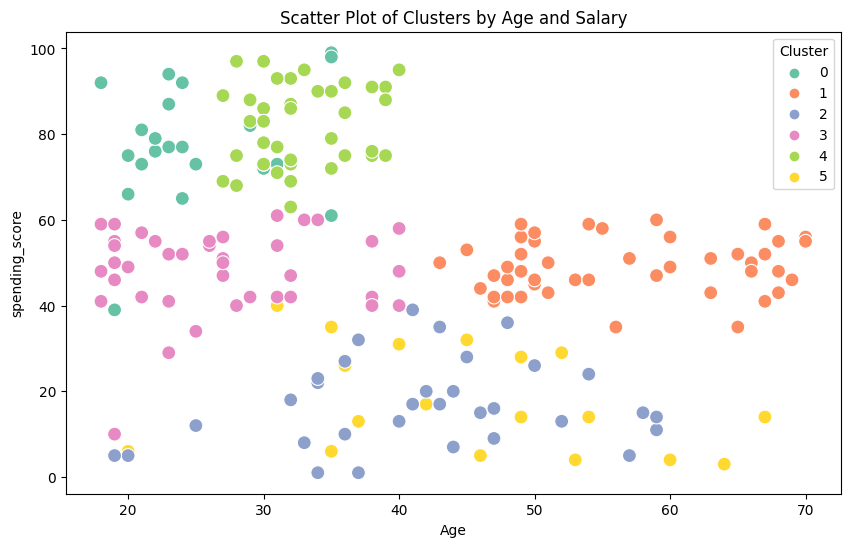

In [32]:
# Scatter plot of Age vs Salary with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='spending_score', hue='Cluster', palette='Set2', s=100)
plt.title('Scatter Plot of Clusters by Age and Spending Score')
plt.show()

## When k=7 the clustering is as follows

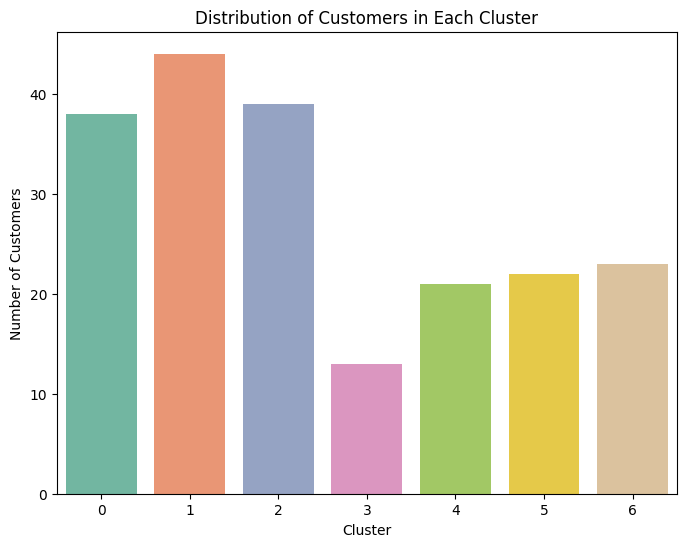

In [39]:
# Plot the distribution of the clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=df, palette='Set2')
plt.title('Distribution of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

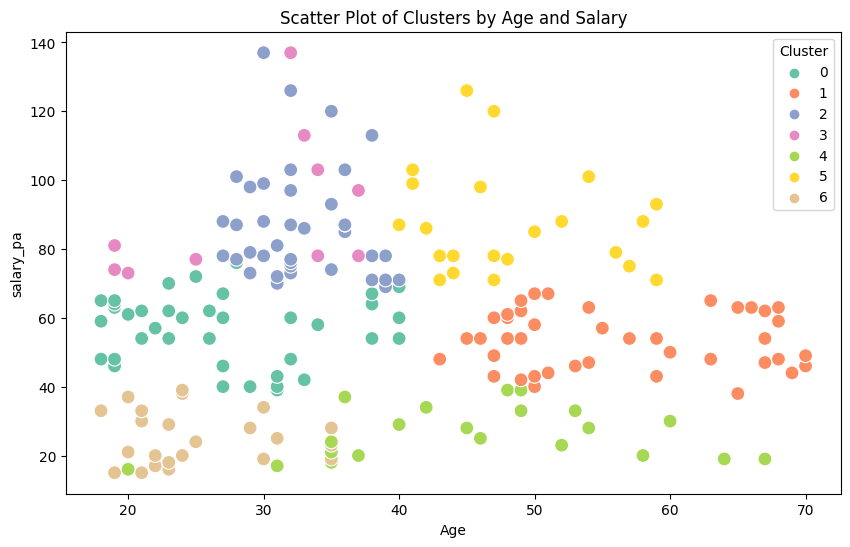

In [40]:
# Scatter plot of Age vs Salary with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='salary_pa', hue='Cluster', palette='Set2', s=100)
plt.title('Scatter Plot of Clusters by Age and Salary')
plt.show()

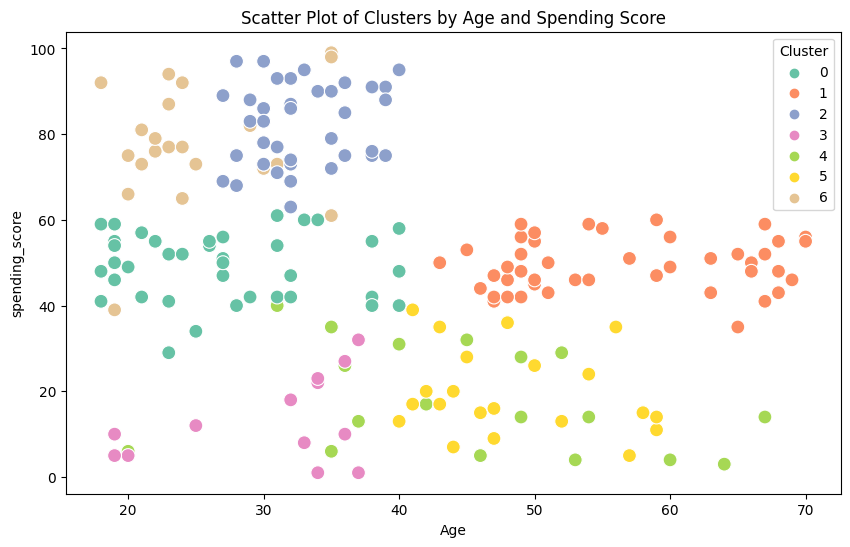

In [42]:
# Scatter plot of Age vs Salary with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='spending_score', hue='Cluster', palette='Set2', s=100)
plt.title('Scatter Plot of Clusters by Age and Spending Score')
plt.show()

## Gaussian Mixture Model (GMM)

**Gaussian Mixture Models (GMMs)** are a probabilistic clustering technique used in unsupervised machine learning to model the data as a mixture of multiple Gaussian distributions, making them more flexible than K-Means for handling clusters.

- It calculates the likelihood that a point belongs to each cluster and assigns it to the one with the highest probability.
- GMM assumes that the data points in each cluster are normally distributed.
- It is a soft clustering method mean, a point can belong to multiple clusters to varying degrees.

## Determining best n_component value for the data using BIC/AIC curve

**BIC/AIC Curve**: The optimal number of components is where BIC or AIC reaches its minimum.

If both curves flatten out at a certain point, that suggests adding more components doesn’t significantly improve the model.

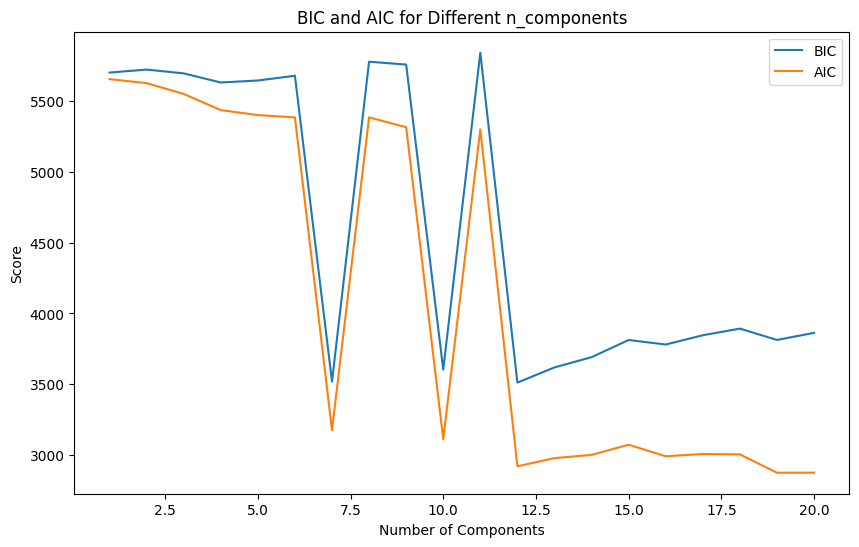

In [53]:
# Define range of n_components to test
n_components_range = range(1, 21)

# Lists to store BIC and AIC values
bic_scores = []
aic_scores = []

# Fit GMM for each n_components and calculate BIC/AIC
for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df[features])
    bic_scores.append(gmm.bic(df[features]))
    aic_scores.append(gmm.aic(df[features]))

# Plot BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC')
plt.plot(n_components_range, aic_scores, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('BIC and AIC for Different n_components')
plt.legend()
plt.show()

Two value of deeps occure hance two potential n_components.
- **n_components = 7** or **n_components = 10**

In [54]:
# Build the Gaussian Mixture Model pipeline
gmm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('gmm', GaussianMixture(n_components=7, random_state=42))
])

In [55]:
# Fit the pipeline to the data
gmm_pipeline.fit(df[features])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'salary_pa',
                                                   'spending_score'])])),
                ('gmm', GaussianMixture(n_components=7, random_state=42))])

In [56]:
# Get the cluster labels
df['Cluster'] = gmm_pipeline['gmm'].predict(gmm_pipeline['preprocessor'].transform(df[features]))

In [57]:
# View the resulting clusters
print(df[['CustomerID', 'Genre', 'Age', 'salary_pa', 'spending_score', 'Cluster']])

     CustomerID   Genre  Age  salary_pa  spending_score  Cluster
0             1    Male   19         15              39        3
1             2    Male   21         15              81        2
2             3  Female   20         16               6        3
3             4  Female   23         16              77        2
4             5  Female   31         17              40        3
..          ...     ...  ...        ...             ...      ...
195         196  Female   35        120              79        5
196         197  Female   45        126              28        4
197         198    Male   32        126              74        5
198         199    Male   32        137              18        4
199         200    Male   30        137              83        5

[200 rows x 6 columns]


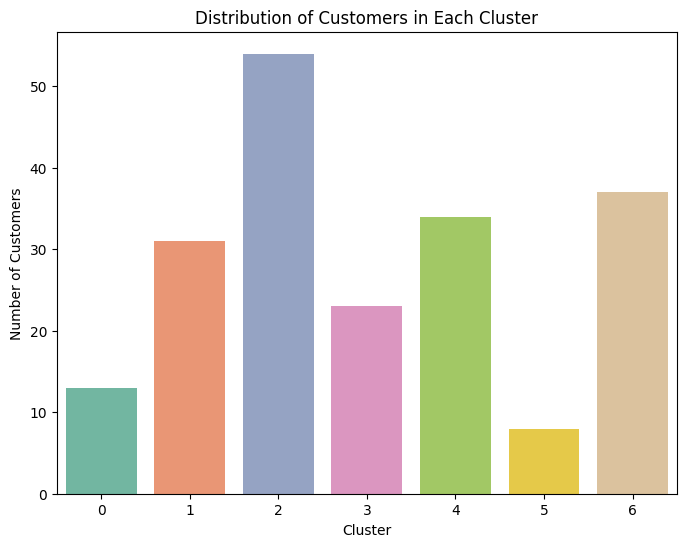

In [58]:
# Plot the distribution of the clusters
plt.figure(figsize=(8, 6))
sns.countplot(x='Cluster', data=df, palette='Set2')
plt.title('Distribution of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

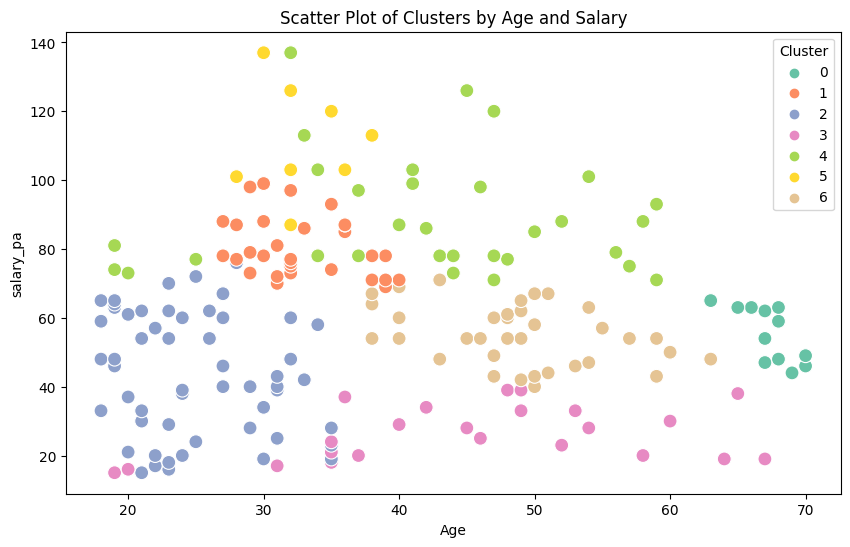

In [59]:
# Scatter plot of Age vs Salary with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='salary_pa', hue='Cluster', palette='Set2', s=100)
plt.title('Scatter Plot of Clusters by Age and Salary')
plt.show()

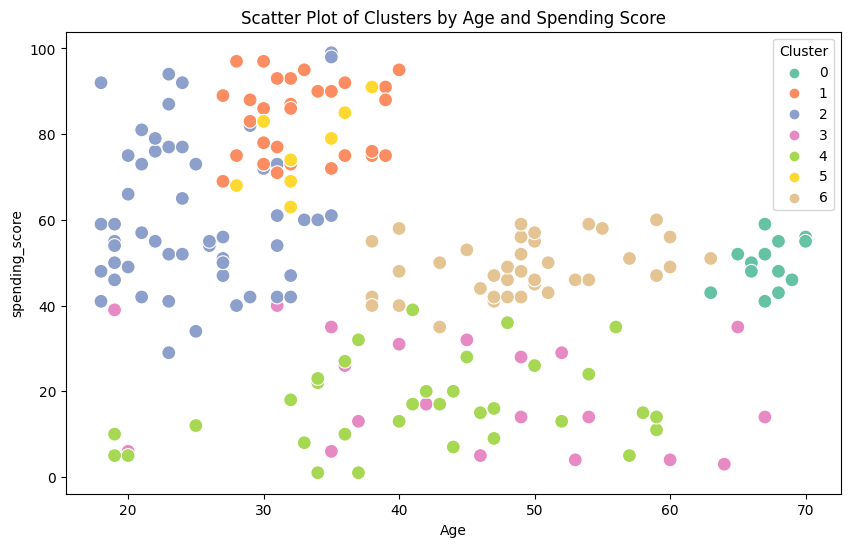

In [60]:
# Scatter plot of Age vs Salary with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='spending_score', hue='Cluster', palette='Set2', s=100)
plt.title('Scatter Plot of Clusters by Age and Spending Score')
plt.show()